In [1]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.interpolate import BSpline

from jax import random
import jax.numpy as jnp
from jax import vmap

import numpyro
import numpyro.distributions as dist
import numpyro.optim as optim
from numpyro.diagnostics import hpdi, print_summary
from numpyro.infer import Predictive, SVI, Trace_ELBO, init_to_value
from numpyro.infer.autoguide import AutoLaplaceApproximation

az.style.use("arviz-darkgrid")

## 4M1
For the model definition simulate observed y values from the prior

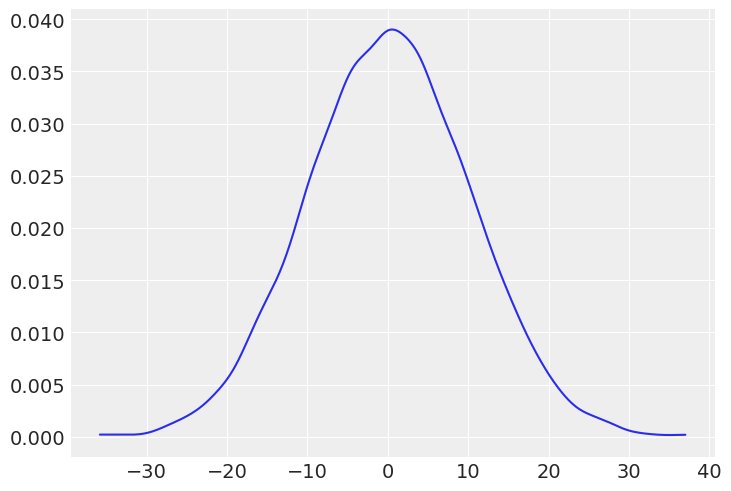

In [3]:
sample_mu = dist.Normal(0, 10).sample(random.PRNGKey(0), (int(1e4),))
sample_sigma = dist.Exponential(1).sample(random.PRNGKey(1), (int(1e4),))
prior_h = dist.Normal(sample_mu, sample_sigma).sample(random.PRNGKey(2))
az.plot_kde(prior_h)
plt.show()

## 4M2
Translate the model into a quap formula

In [4]:
def flist(obs):
    mu = numpyro.sample("mu", dist.Normal(0, 10))
    sigma = numpyro.sample("sigma", dist.Exponential(1))
    numpyro.sample("obs", dist.Normal(mu, sigma), obs=obs)

## 4M3
Translate the quap model formula into a mathematical model definition

$$
y \sim Normal(a + bx, \sigma) \\
a \sim Normal(0, 10) \\
b \sim Uniform(0, 1) \\
\sigma \sim Exponential(1)
$$

## 4M4
A sample of students is measured for height each year for 3 years. After the third year, you want
to fit a linear regression predicting height using year as a predictor. Write down the mathematical
model definition for this regression, using any variable names and priors you choose. Be prepared to
defend your choice of priors.

$$
y \sim Normal(a + bx, \sigma) \\
a \sim Normal(150, 20) \\
b \sim HalfNormal(1) \\
\sigma \sim Exponential(.1)
$$

## 4M5
Now suppose I remind you that every student got taller each year. Does this information lead you to change your choice of piors? How?  
Answer: No

## 4M6
Now suppose I tell you that the variance among heights for students of the same age is never more than 64 cm. How does this lead you to revise your priors?  
Answer: I would adjust $\sigma$ so the prior predictive contain most of the mass within an 64 cm interval.

## 4M7
Refit model _m4.3_ from the chapter, but omit the mean weight _xbar_ this time. Compare the new model's posterior to that of the original model. In particular, look at the covariance among the parameters. What is different? Then compare the posterior predictions of both models.

In [7]:
# load data 
d = pd.read_csv("data/Howell1.csv", sep=";")
d2 = d[d["age"] >= 18]

# define the average weight, x-bar
xbar = d2.weight.mean()

# fit model
def model(weight, height):
    a = numpyro.sample("a", dist.Normal(178, 20))
    b = numpyro.sample("b", dist.LogNormal(0, 1))
    sigma = numpyro.sample("sigma", dist.Uniform(0, 50))
    mu = numpyro.deterministic("mu", a + b * (weight - xbar))
    numpyro.sample("height", dist.Normal(mu, sigma), obs=height)


m4_3_1 = AutoLaplaceApproximation(model)
svi = SVI(
    model, m4_3_1, optim.Adam(1), Trace_ELBO(), weight=d2.weight.values, height=d2.height.values
)
svi_result_1 = svi.run(random.PRNGKey(0), 2000)
p4_3_1 = svi_result_1.params
samples_1 = m4_3_1.sample_posterior(random.PRNGKey(1), p4_3_1, (1000,))
samples_1.pop("mu");

100%|██████████| 2000/2000 [00:00<00:00, 2894.85it/s, init loss: 40631.5391, avg. loss [1901-2000]: 1078.9297]


In [8]:
d2.head()

,height,weight,age,male
0,151.765,47.825606,63.0,1
1,139.700,36.485807,63.0,0
2,136.525,31.864838,65.0,0
3,156.845,53.041914,41.0,1
4,145.415,41.276872,51.0,0


In [9]:
def model(weight, height):
    a = numpyro.sample("a", dist.Normal(178, 20))
    b = numpyro.sample("b", dist.LogNormal(0, 1))
    sigma = numpyro.sample("sigma", dist.Uniform(0, 50))
    mu = numpyro.deterministic("mu", a + b * weight)
    numpyro.sample("height", dist.Normal(mu, sigma), obs=height)

m4_3_2 = AutoLaplaceApproximation(model)
svi = SVI(
    model, m4_3_2, optim.Adam(1), Trace_ELBO(), weight=d2.weight.values, height=d2.height.values
)
svi_result_2 = svi.run(random.PRNGKey(0), 2000)
p4_3_2 = svi_result_2.params
samples_2 = m4_3_2.sample_posterior(random.PRNGKey(1), p4_3_2, (1000,))
samples_2.pop("mu");

100%|██████████| 2000/2000 [00:00<00:00, 2891.40it/s, init loss: 21101.8516, avg. loss [1901-2000]: 1083.3383]


Comparison of parameter covariances

In [10]:
vcov = jnp.cov(jnp.stack(list(samples_1.values()), axis=0))
jnp.round(vcov, 2)

DeviceArray([[0.08, 0.  , 0.  ],
             [0.  , 0.  , 0.  ],
             [0.  , 0.  , 0.04]], dtype=float32)

In [11]:
vcov = jnp.cov(jnp.stack(list(samples_2.values()), axis=0))
jnp.round(vcov, 2)

DeviceArray([[ 3.69, -0.08,  0.02],
             [-0.08,  0.  ,  0.  ],
             [ 0.02,  0.  ,  0.04]], dtype=float32)

Comparison of posterior predictives

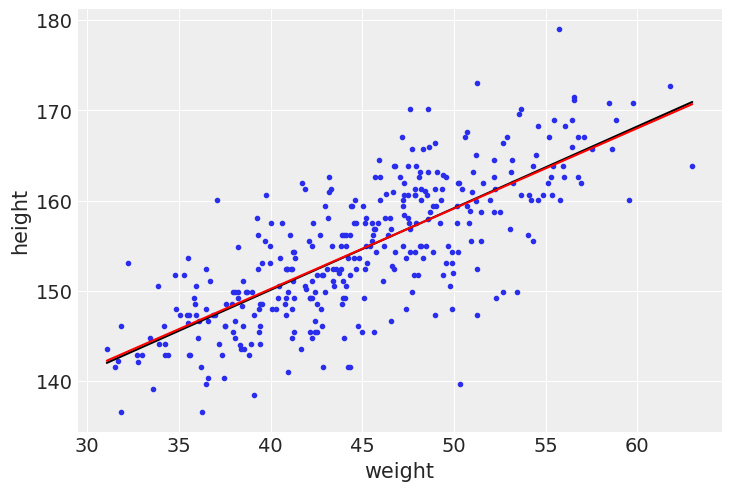

In [12]:
az.plot_pair(d2[["weight", "height"]].to_dict(orient="list"))

post_1 = m4_3_1.sample_posterior(random.PRNGKey(1), p4_3_1, (1000,))
a_map_1 = jnp.mean(post_1["a"])
b_map_1 = jnp.mean(post_1["b"])

post_2 = m4_3_2.sample_posterior(random.PRNGKey(1), p4_3_2, (1000,))
a_map_2 = jnp.mean(post_2["a"])
b_map_2 = jnp.mean(post_2["b"])

x = jnp.linspace(d2.weight.min(), d2.weight.max(), 101)
plt.plot(x, a_map_1 + b_map_1 * (x - xbar), "k")
plt.plot(x, a_map_2 + b_map_2 * x, "r")

plt.show()

## 4M8
Increase the number of knots from 15 in the cherry blossom spline example and observe what happens.

In [15]:
d = pd.read_csv("data/cherry_blossoms.csv", sep=";")
d2 = d[d.doy.notna()]  # complete cases on doy

In [38]:
def fit_spline(num_knots: int = 15, weight_prior_std: int = 10, ax: list = None):
    knot_list = jnp.quantile(
        d2.year.values.astype(float), q=jnp.linspace(0, 1, num=num_knots)
    )

    knots = jnp.pad(knot_list, (3, 3), mode="edge")
    B = BSpline(knots, jnp.identity(num_knots + 2), k=3)(d2.year.values)
    def model(B, D):
        a = numpyro.sample("a", dist.Normal(100, 10))
        w = numpyro.sample("w", dist.Normal(0, weight_prior_std).expand(B.shape[1:]))
        sigma = numpyro.sample("sigma", dist.Exponential(1))
        mu = numpyro.deterministic("mu", a + B @ w)
        numpyro.sample("D", dist.Normal(mu, sigma), obs=D)


    start = {"w": jnp.zeros(B.shape[1])}
    m4_7 = AutoLaplaceApproximation(model, init_loc_fn=init_to_value(values=start))
    svi = SVI(model, m4_7, optim.Adam(1), Trace_ELBO(), B=B, D=d2.doy.values)
    svi_result = svi.run(random.PRNGKey(0), 20000)
    p4_7 = svi_result.params
    post = m4_7.sample_posterior(random.PRNGKey(1), p4_7, (1000,))
    w = jnp.mean(post["w"], 0)

    if ax is None:
        fig, ax = plt.subplots(ncols=2, figsize=(10, 5))
    ax[0].plot(
        xlim=(d2.year.min(), d2.year.max()),
        ylim=(-6, 6),
        xlabel="year",
        ylabel="basis * weight",
    )
    for i in range(B.shape[1]):
        ax[0].plot(d2.year, (w[i] * B[:, i]), "k", alpha=0.5)


    mu = post["mu"]
    mu_PI = jnp.percentile(mu, q=(1.5, 98.5), axis=0)
    az.plot_pair(
        d2[["year", "doy"]].astype(float).to_dict(orient="list"),
        scatter_kwargs={"c": "royalblue", "alpha": 0.3, "markersize": 10},
        ax=ax[1]
    )
    ax[1].fill_between(d2.year, mu_PI[0], mu_PI[1], color="k", alpha=0.5)

100%|██████████| 20000/20000 [00:01<00:00, 14170.76it/s, init loss: 190557536.0000, avg. loss [19001-20000]: 2726.8022]


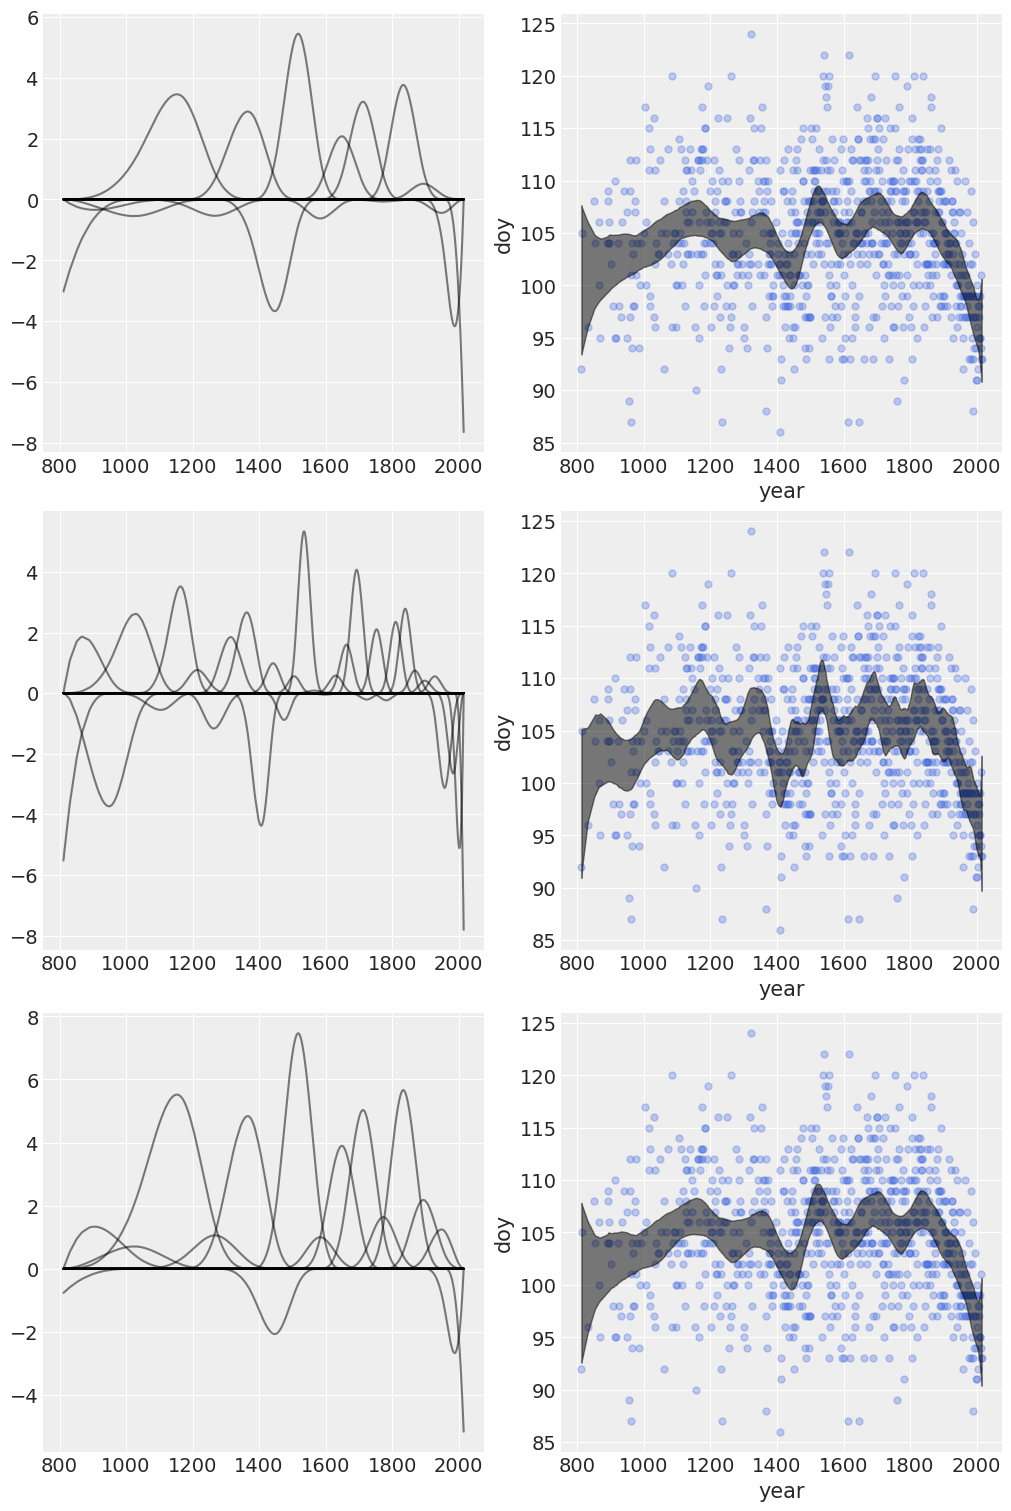

In [43]:
fig, axes = plt.subplots(ncols = 2, nrows = 3, figsize=(10, 15))
fit_spline(num_knots=15, weight_prior_std=10, ax=axes[0])
fit_spline(num_knots=30, weight_prior_std=10, ax=axes[1])
fit_spline(num_knots=15, weight_prior_std=40, ax=axes[2])
plt.show()

## 4H1
Predict the posterior distribution for 5 new individuals

In [51]:
# load data 
d = pd.read_csv("data/Howell1.csv", sep=";")
d2 = d[d["age"] >= 18]

# define the average weight, x-bar
xbar = d2.weight.mean()

# fit model
def model(weight, height=None):
    a = numpyro.sample("a", dist.Normal(178, 20))
    b = numpyro.sample("b", dist.LogNormal(0, 1))
    sigma = numpyro.sample("sigma", dist.Uniform(0, 50))
    mu = numpyro.deterministic("mu", a + b * (weight - xbar))
    numpyro.sample("height", dist.Normal(mu, sigma), obs=height)

h41 = AutoLaplaceApproximation(model)
svi = SVI(
    model, h41, optim.Adam(1), Trace_ELBO(), weight=d2.weight.values, height=d2.height.values
)
svi_result = svi.run(random.PRNGKey(0), 2000)
p41 = svi_result.params
post = h41.sample_posterior(random.PRNGKey(1), p41, (1000,))

new_sample = [46.95, 43.72, 64.78, 32.59, 54.63]
predictive = Predictive(h41.model, post)
prediction = predictive(random.PRNGKey(2), new_sample)["height"]

100%|██████████| 2000/2000 [00:00<00:00, 2845.48it/s, init loss: 40631.5391, avg. loss [1901-2000]: 1078.9297]


Expected height

In [55]:
jnp.mean(prediction, axis=0)

DeviceArray([156.6052 , 153.59355, 172.57988, 143.43314, 163.22388], dtype=float32)

89% interval

In [54]:
jnp.percentile(prediction, q=(5.5, 94.5), axis=0)

DeviceArray([[148.45569, 145.25323, 164.54808, 135.3933 , 155.15538],
             [164.58948, 161.73181, 181.04396, 151.88374, 171.47188]],            dtype=float32)

## 4H2
Select out all the rows in the Howell1 data with ages below 18 years of age. If you do it right,
you should end up with a new data frame with 192 rows in it.

(a) Fit a linear regression to these data, using quap. Present and interpret the estimates. For every
10 units of increase in weight, how much taller does the model predict a child gets?

(b) Plot the raw data, with height on the vertical axis and weight on the horizontal axis. Super-
impose the MAP regression line and 89% HPDI for the mean. Also superimpose the 89% HPDI for predicted heights.

(c) What aspects of the model fit concern you? Describe the kinds of assumptions you would
change, if any, to improve the model. You don’t have to write any new code. Just explain what the
model appears to be doing a bad job of, and what you hypothesize would be a better model.

In [12]:
# load data 
d = pd.read_csv("data/Howell1.csv", sep=";")
d = d[d["age"] < 18]

In [13]:
# define the average weight, x-bar
xbar = d.weight.mean()

# fit model
def model(weight, height=None):
    a = numpyro.sample("a", dist.Normal(100, 20))
    b = numpyro.sample("b", dist.LogNormal(0, 1))
    sigma = numpyro.sample("sigma", dist.Uniform(0, 50))
    mu = numpyro.deterministic("mu", a + b * (weight - xbar))
    numpyro.sample("height", dist.Normal(mu, sigma), obs=height)

h42 = AutoLaplaceApproximation(model)
svi = SVI(
    model, h42, optim.Adam(1), Trace_ELBO(), weight=d.weight.values, height=d.height.values
)
svi_result = svi.run(random.PRNGKey(0), 2000)
post = h42.sample_posterior(random.PRNGKey(1), svi_result.params, (1000,))

100%|██████████| 2000/2000 [00:00<00:00, 3065.12it/s, init loss: 11479.5479, avg. loss [1901-2000]: 689.7674]


a) How much taller des the model predict the child gets for every 10 units of increase in weight

In [14]:
jnp.mean(post["b"]) * 10

DeviceArray(26.971865, dtype=float32)

b)

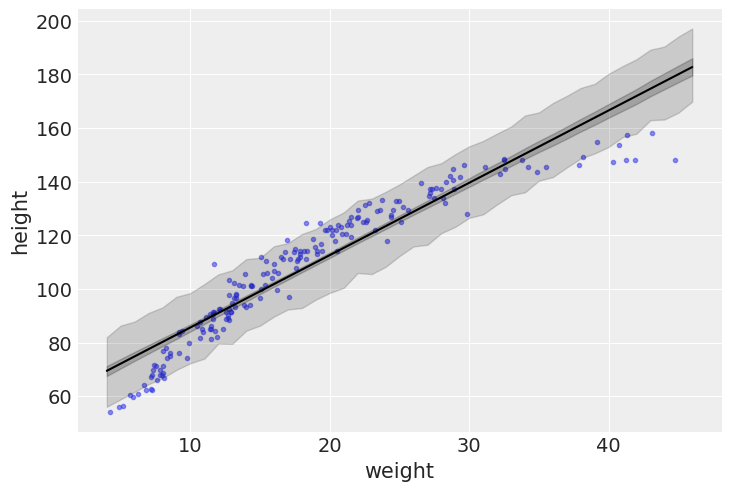

In [15]:
mu_link = lambda weight: post["a"] + post["b"] * (weight - d.weight.mean())
weight_seq = jnp.arange(start=round(d["weight"].min()), stop=round(d["weight"].max()) + 2, step=1)
mu = vmap(mu_link)(weight_seq).T
mu_mean = jnp.mean(mu, 0)
mu_HPDI = hpdi(mu, prob=0.89, axis=0)
sim_height = Predictive(h42.model, post, return_sites=["height"])(
    random.PRNGKey(2), weight_seq, None
)["height"]
height_HPDI = hpdi(sim_height, prob=0.89, axis=0)

# plot raw data
az.plot_pair(
    d[["weight", "height"]].to_dict(orient="list"), scatter_kwargs={"alpha": 0.5}
)

# draw MAP line
plt.plot(weight_seq, mu_mean, "k")

# draw HPDI region for line
plt.fill_between(weight_seq, mu_HPDI[0], mu_HPDI[1], color="k", alpha=0.2)

# draw PI region for simulated heights
plt.fill_between(weight_seq, height_HPDI[0], height_HPDI[1], color="k", alpha=0.15)
plt.show()

c) A linear fit seems like a bad choice

## 4H3
Suppose a colleague of yours, who works on allometry, glances at the practice problems just
above. Your colleague exclaims, “That’s silly. Everyone knows that it’s only the logarithm of body
weight that scales with height!” Let’s take your colleague’s advice and see what happens.
(a) Model the relationship between height (cm) and the natural logarithm of weight (log-kg). Use
the entire Howell1 data frame, all 544 rows, adults and non-adults.

In [16]:
# load data 
d43 = pd.read_csv("data/Howell1.csv", sep=";")
#d2["weight"] = np.log(d2["weight"])

# fit model
def model(weight, height=None):
    a = numpyro.sample("a", dist.Normal(150, 20))
    b = numpyro.sample("b", dist.Normal(0, 100))
    sigma = numpyro.sample("sigma", dist.Uniform(0, 50))
    mu = numpyro.deterministic("mu", a + b * (jnp.log(weight) - jnp.log(d43.weight.mean())))
    numpyro.sample("height", dist.Normal(mu, sigma), obs=height)

h43 = AutoLaplaceApproximation(model)
svi = SVI(
    model, h43, optim.Adam(1), Trace_ELBO(), weight=d43.weight.values, height=d43.height.values
)
svi_result = svi.run(random.PRNGKey(0), 2000)
post43 = h43.sample_posterior(random.PRNGKey(1), svi_result.params, (1000,))

100%|██████████| 2000/2000 [00:00<00:00, 3549.79it/s, init loss: 50417.9961, avg. loss [1901-2000]: 1673.8734]


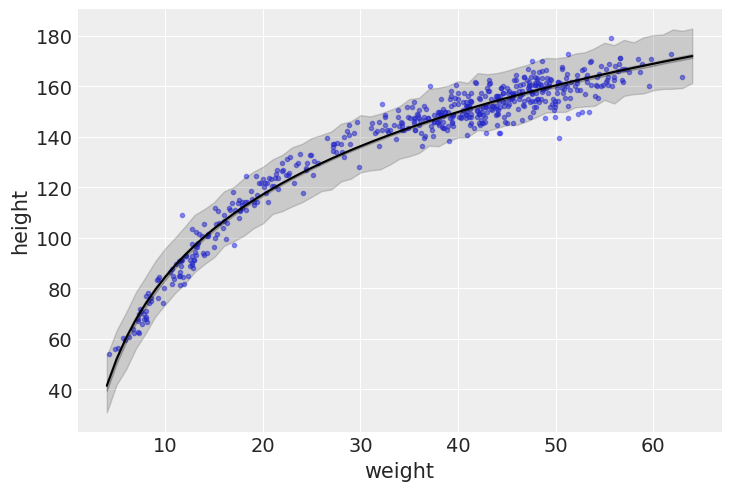

In [17]:
mu_link = lambda weight: post43["a"] + post43["b"] * (jnp.log(weight) - jnp.log(d43.weight.mean()))
weight_seq = jnp.arange(start=round(d43["weight"].min()), stop=round(d43["weight"].max()) + 2, step=1)
mu = vmap(mu_link)(weight_seq).T
mu_mean = jnp.mean(mu, 0)
mu_HPDI = hpdi(mu, prob=0.97, axis=0)
sim_height = Predictive(h43.model, post43, return_sites=["height"])(
    random.PRNGKey(2), weight_seq, None
)["height"]
height_HPDI = hpdi(sim_height, prob=0.97, axis=0)

# plot raw data
az.plot_pair(
    d43[["weight", "height"]].to_dict(orient="list"), scatter_kwargs={"alpha": 0.5}
)

# draw MAP line
plt.plot(weight_seq, mu_mean, "k")

# draw HPDI region for line
plt.fill_between(weight_seq, mu_HPDI[0], mu_HPDI[1], color="k", alpha=0.2)

# draw PI region for simulated heights
plt.fill_between(weight_seq, height_HPDI[0], height_HPDI[1], color="k", alpha=0.15)
plt.show()

## 4H4


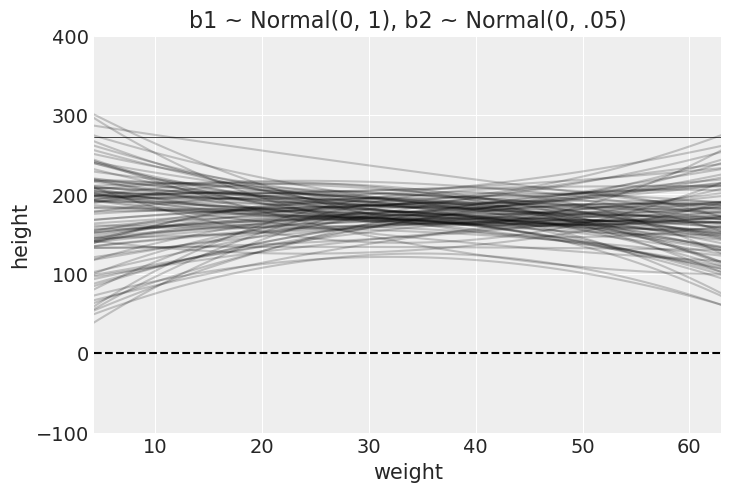

In [37]:
d44 = pd.read_csv("data/Howell1.csv", sep=";")

with numpyro.handlers.seed(rng_seed=2971):
    N = 100  # 100 lines
    a = numpyro.sample("a", dist.Normal(178, 20).expand([N]))
    b1 = numpyro.sample("b1", dist.Normal(0, 1).expand([N]))
    b2 = numpyro.sample("b2", dist.Normal(0, .05).expand([N]))

plt.subplot(
    xlim=(d44["weight"].min(), d44["weight"].max()),
    ylim=(-100, 400),
    xlabel="weight",
    ylabel="height",
)
plt.axhline(y=0, c="k", ls="--")
plt.axhline(y=272, c="k", ls="-", lw=0.5)
plt.title("b1 ~ Normal(0, 1), b2 ~ Normal(0, .05)")
xbar = d44["weight"].mean()
x = jnp.linspace(d44["weight"].min(), d44["weight"].max(), 101)
for i in range(N):
    plt.plot(x, a[i] + b1[i] * (x - xbar) + b2[i] * (x - xbar)**2, "k", alpha=0.2)
plt.show()



## 4H5

In [33]:
x1

DeviceArray([-2.130431  , -2.0905237 , -2.0506165 , -2.0107093 ,
             -1.9708021 , -1.9308947 , -1.8909874 , -1.8510804 ,
             -1.8111731 , -1.7712657 , -1.7313586 , -1.6914513 ,
             -1.6515442 , -1.611637  , -1.5717297 , -1.5318226 ,
             -1.4919153 , -1.452008  , -1.4121008 , -1.3721936 ,
             -1.3322864 , -1.2923791 , -1.2524717 , -1.2125646 ,
             -1.1726575 , -1.1327502 , -1.0928429 , -1.0529358 ,
             -1.0130286 , -0.97312135, -0.933214  , -0.89330673,
             -0.8533996 , -0.81349224, -0.77358496, -0.7336778 ,
             -0.69377065, -0.6538634 , -0.6139562 , -0.57404906,
             -0.5341417 , -0.49423456, -0.4543274 , -0.41441995,
             -0.3745128 , -0.33460563, -0.29469824, -0.25479108,
             -0.21488392, -0.17497659, -0.13506943, -0.09516227,
             -0.055255  , -0.01534784,  0.02455956,  0.06446677,
              0.10437393,  0.14428121,  0.1841883 ,  0.22409558,
              0.26400298,